In [14]:
import skimage as sk
from skimage.io import imread, imshow, imsave
import numpy as np
import os
from glob import glob
import napari
import pyclesperanto as cle
import matplotlib.pyplot as plt

In [4]:
cle.select_device("NVIDIA")

(OpenCL) NVIDIA RTX A4000 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              572.83
	Device Type:                 GPU
	Compute Units:               48
	Global Memory Size:          16375 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         4093 MB
	Max Clock Frequency:         1560 MHz
	Image Support:               Yes

### Reading in images

In [9]:
#set voxel size for images
voxel_size_x = 0.301
voxel_size_y = 0.301
voxel_size_z = 4.55
voxels = [voxel_size_z, voxel_size_y, voxel_size_x]

In [6]:
CMO_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/Control_MO/*.tif'))
GMO_1ng_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/GNAS_MO_1ng/*.tif'))
GMO_2ng_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/GNAS_MO_2ng/*.tif'))

In [7]:
CMO_imgs = list(map(sk.io.imread,CMO_files))
GMO_1ng_imgs = list(map(sk.io.imread,GMO_1ng_files))
GMO_2ng_imgs = list(map(sk.io.imread,GMO_2ng_files))

In [10]:
viewer = napari.view_image(GMO_1ng_imgs[1], name= 'test', scale = voxels)

## Plan: preprocess, threshold signal, connected components, post-process objects, measure volume and SA to get ratio, measure fluorescence values, PCA on volume/SA to find threshold for splitting into active and inactive state?

#### Trying to get GPU use working

In [11]:
test_img = GMO_1ng_imgs[1]

array([[[106, 106, 103, ..., 100, 105, 102],
        [107, 106, 115, ..., 100,  95, 106],
        [104, 106, 104, ...,  99, 109, 107],
        ...,
        [105, 103, 103, ...,  97,  96,  98],
        [108, 107,  99, ..., 104, 107, 107],
        [106, 103, 107, ...,  95,  98, 104]],

       [[106, 103,  98, ..., 100,  96,  98],
        [111, 105, 103, ..., 107,  96, 102],
        [102,  99, 102, ..., 105, 101, 106],
        ...,
        [109, 109, 108, ..., 102, 100, 101],
        [102, 104, 105, ..., 102, 104, 113],
        [108, 101, 107, ..., 105, 109, 109]],

       [[103, 103, 101, ..., 109,  96, 104],
        [106, 101, 101, ..., 106, 112, 103],
        [110, 104, 104, ..., 102, 100, 101],
        ...,
        [102, 105, 106, ..., 102,  97, 111],
        [100, 106, 106, ..., 111,  98, 104],
        [103, 103, 106, ...,  98, 101, 101]],

       ...,

       [[105, 101, 100, ..., 103, 103,  99],
        [108, 106, 100, ..., 101, 102, 104],
        [110,  99, 101, ..., 102, 100, 110],
        ...,
        [115, 105, 112, ..., 101,  98,  99],
        [ 96, 103, 103, ..., 105, 109, 103],
        [102, 107, 106, ..., 112, 106, 106]],

       [[105, 105, 103, ..., 109, 103, 103],
        [111,  99, 105, ..., 108, 103, 103],
        [109, 100, 103, ...,  98, 101, 108],
        ...,
        [116, 103, 106, ..., 100,  98,  92],
        [102, 103, 104, ..., 108, 103, 107],
        [105, 109, 105, ...,  99, 107, 106]],

       [[104, 108, 105, ..., 100, 101, 103],
        [101, 103,  97, ..., 103, 104, 104],
        [104, 101,  99, ..., 109, 112, 109],
        ...,
        [100, 101, 107, ..., 107, 104, 107],
        [105,  99, 103, ..., 108, 105, 113],
        [ 98, 108, 100, ..., 105, 105, 108]]], dtype=uint16, mtype=buffer)
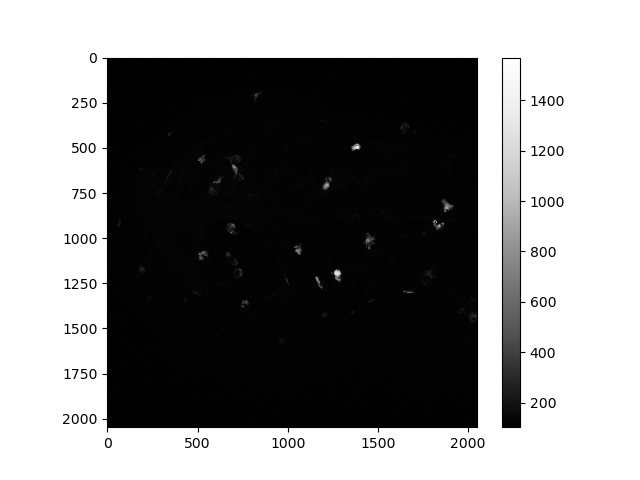
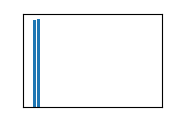

In [12]:
input_gpu = cle.push(test_img)
input_gpu

Inspect 3D data

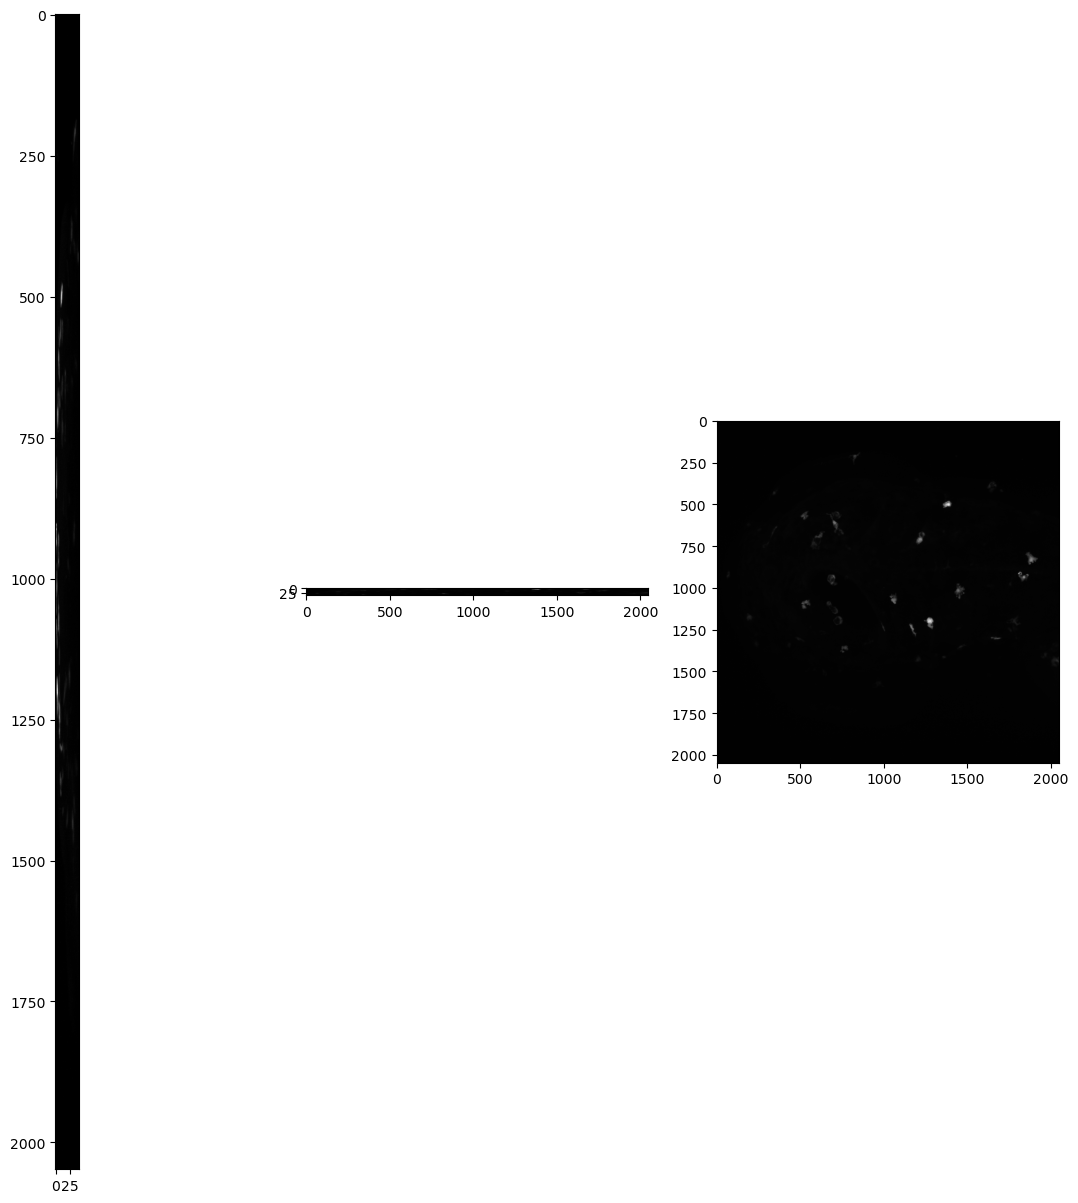

(42, 2048, 2048)


In [15]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(projection_x, cmap='prism' if labels else 'gray')
    axs[1].imshow(projection_y, cmap='prism' if labels else 'gray')
    axs[2].imshow(projection_z, cmap='prism' if labels else 'gray')
    plt.show()

show(input_gpu)
print(input_gpu.shape)

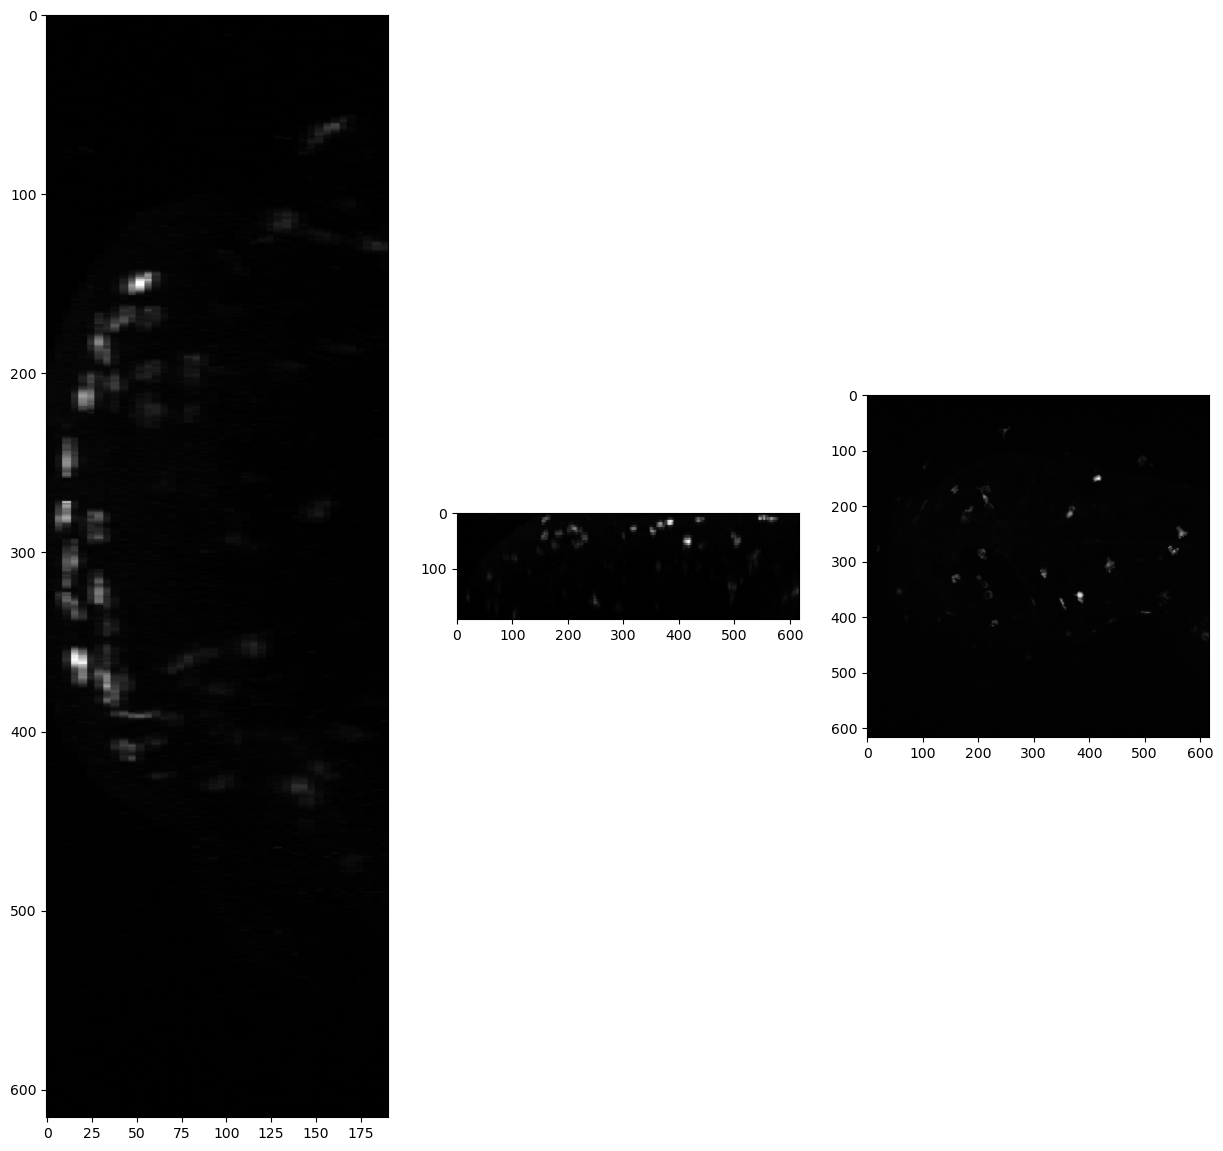

(191, 616, 616)


In [16]:
#Resample to make isotropic
resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)

show(resampled)
print(resampled.shape)

May not have enough Z resolution for resonable reasults

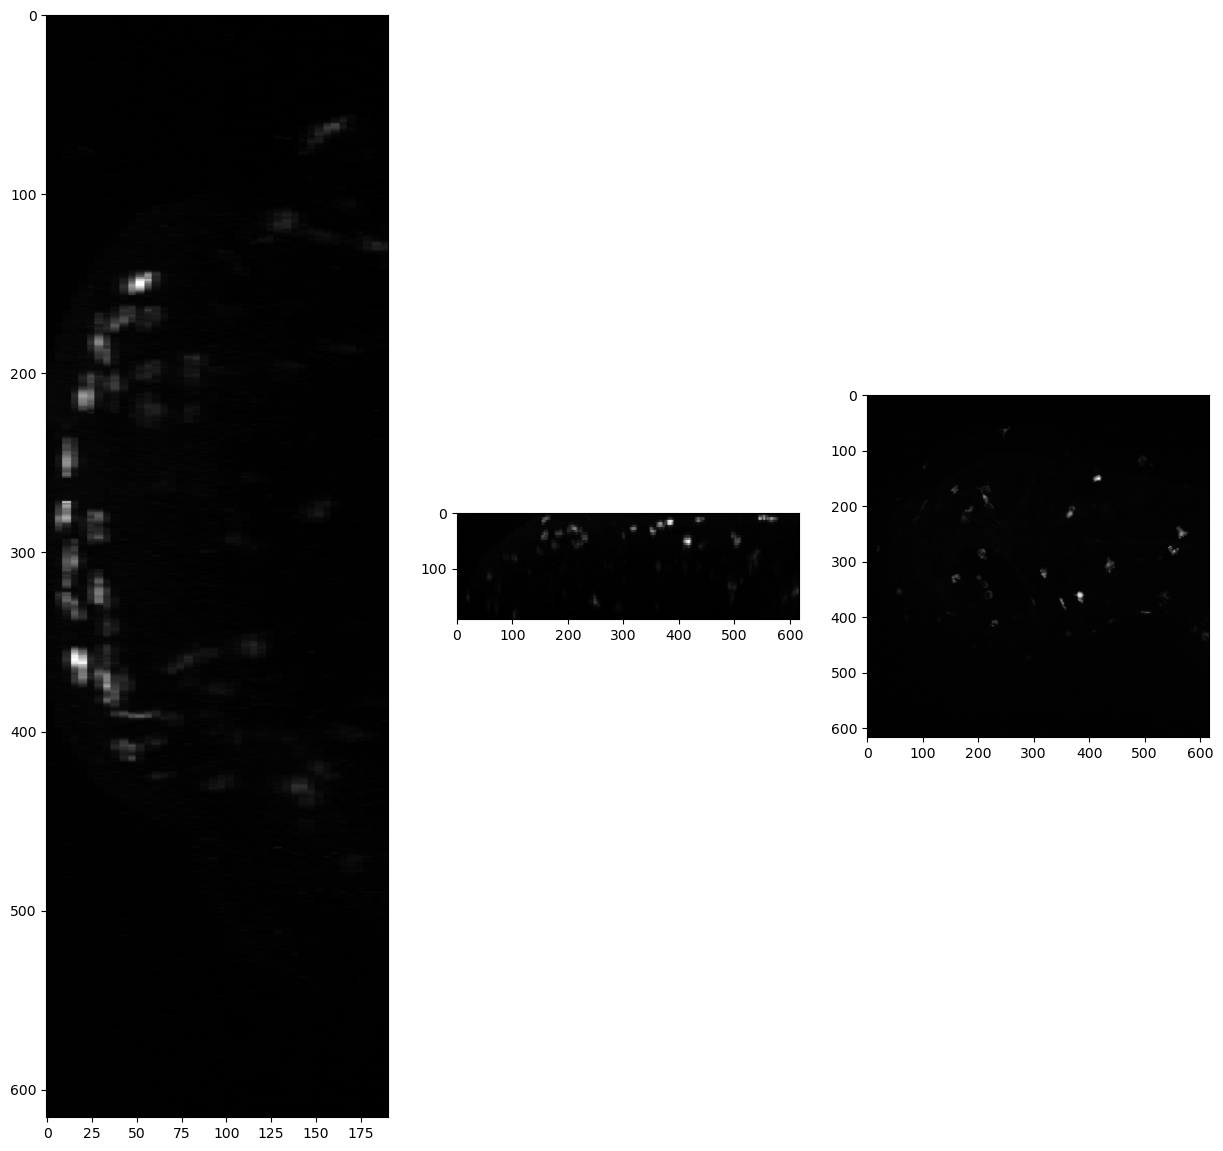

In [17]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[2]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # get a single slice out of the stack
    cle.copy_slice(resampled, a_slice, z)
    # measure its intensity
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

show(equalized_intensities_stack)

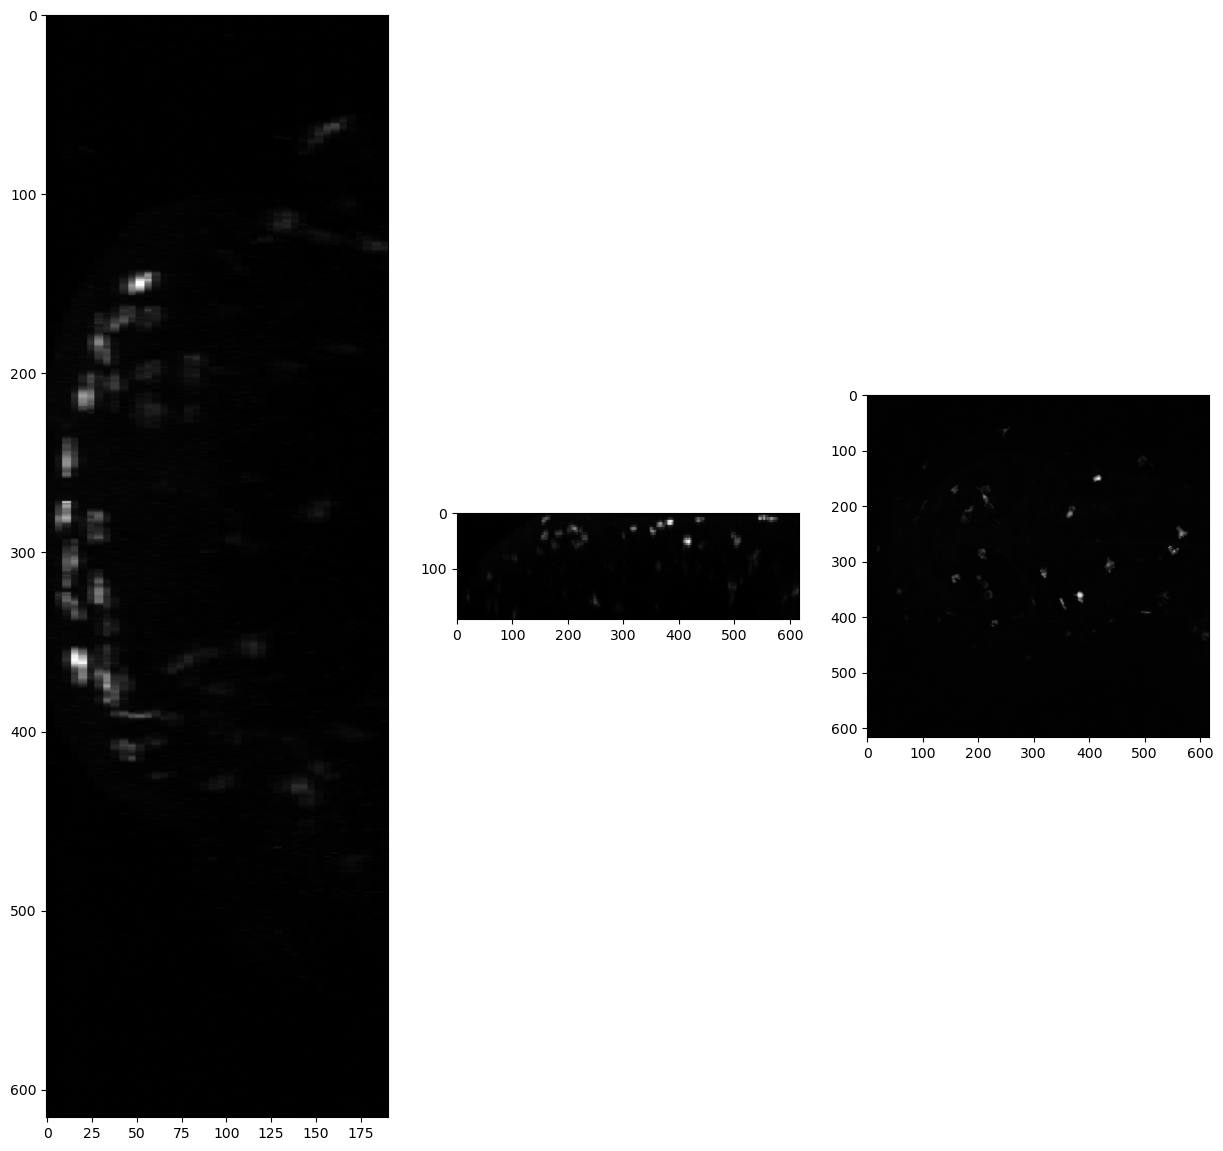

In [29]:
#Correct background
background_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=10, radius_y=10, radius_z=10)
show(background_subtracted)

In [ ]:
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=5, outline_sigma=2)
show(segmented, labels=True)

In [34]:
help(cle.detect_maxima_box)

Help on function detect_maxima_box in module pyclesperanto:

detect_maxima_box(input_image: Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array], output_image: Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array, NoneType] = None, radius_x: float = 0, radius_y: float = 0, radius_z: float = 0, device: Optional[pyclesperanto._pyclesperanto._Device] = None) -> Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array]
    Detects local maxima in a given square/cubic neighborhood. Pixels in the
    resulting image are set to 1 if there is no other pixel in a given radius which
    has a higher intensity, and to 0 otherwise.
    
    Parameters
    ----------
    input_image: Image
        Input image to process.
    output_image: Optional[Image] (= None)
        Output result image.
    radius_x: float (= 0)
        Radius along the x axis.
    radius_y: float (= 0)
        Radius along the y axis.
    radius_z: float (= 0)
        Radius along the z axis.
    device: Optional[Dev

In [49]:
sigma_spot_detection = 7
blurred = cle.gaussian_blur(background_subtracted, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)
#enough of a blue to remove most of the texture of the objects wihle retaining their presence

detected_spots = cle.detect_maxima_box(blurred, radius_x=1, radius_y=1, radius_z=1)

number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("number of detected spots", number_of_spots)
viewer = napari.view_image(blurred, name='blurred')
viewer.add_image(detected_spots, name='spots')
# fig, axs = plt.subplots(1, 2, figsize=(15, 15))
# axs[0].imshow(blurred[95,300:500,300:])
# axs[1].imshow(detected_spots[95,300:500,300:])
# plt.show()

number of detected spots 1063.0


<Image layer 'spots' at 0x21152babb80>

In [55]:
sigma_outline = 1
blurred = cle.gaussian_blur(background_subtracted, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
#Smaller blur to make threhsolding easier and maintain reasonable boundaries

binary = cle.threshold_otsu(blurred)
viewer = napari.view_image(blurred, name='blurred')
viewer.add_image(binary, name='mask')

<Image layer 'mask' at 0x2114df458b0>

In [62]:
#testing Triangle threshold
blurred = cle.pull(blurred)
thresh = sk.filters.threshold_triangle(blurred)
mask = blurred > thresh

viewer = napari.view_image(blurred, name='blurred')
viewer.add_image(mask, name='mask')

<Image layer 'mask' at 0x211a53a4b80>

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 800x500 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

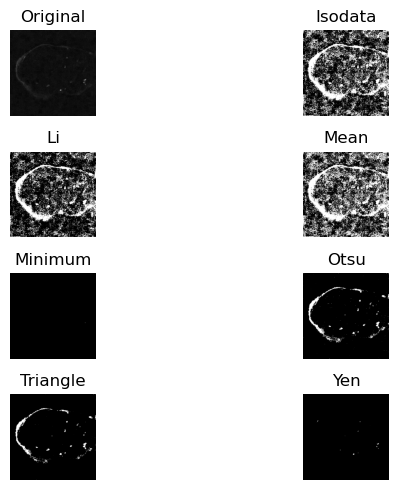

In [60]:
sk.filters.try_all_threshold(blurred[90,:,:], figsize=(8, 5), verbose=True)